
## SVM Classification on Pulsar Star Dataset
- Objective: This assignment is designed to help you develop a deeper understanding of Support Vector Machines (SVMs) for classification. You will experiment with various kernel functions and hyperparameters, analyze model performance, and interpret classification metrics.

- Author: Xujia Qin
- Date: 9th Jun 2025
- Dataset: Pulsar Star Dataset which contains eight continuous features extracted from the HTRU2 dataset and a binary target variable indicating whether a candidate is a pulsar star (1) or not (0).

### 1. Data Loading and Preprocessing

In [ ]:
# Import Libs
%pip install seaborn
%pip install scikit-learn
%pip install tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from tqdm import tqdm



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1. Data Loading and Preprocessing

In [3]:
# Load the dataset
df = pd.read_csv("pulsar_stars.csv")

# Rename columns for easier access
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

# Check for missing values
print(df.isnull().sum())

Mean_of_the_integrated_profile                  0
Standard_deviation_of_the_integrated_profile    0
Excess_kurtosis_of_the_integrated_profile       0
Skewness_of_the_integrated_profile              0
Mean_of_the_DM-SNR_curve                        0
Standard_deviation_of_the_DM-SNR_curve          0
Excess_kurtosis_of_the_DM-SNR_curve             0
Skewness_of_the_DM-SNR_curve                    0
target_class                                    0
dtype: int64


In [4]:
# Split features and target
X = df.drop("target_class", axis=1)
y = df["target_class"]

# Normalize the feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 2. Model Building and Hyperparameter Tuning

In [ ]:
# Define kernel types to explore
kernels = ['linear', 'rbf', 'sigmoid', 'poly']

# Define the parameter space
param_distributions = {
    "C": [0.1, 1, 10],
    "gamma": ['scale', 0.01, 1],
    "degree": [2, 3, 4]  # Only used for poly kernel
}


In [ ]:
# Train multiple SVM models
# Initialize a list to store results
results = []

# Iterate over each kernel type
for kernel in tqdm(kernels, desc="Training SVM Kernels"):
    if kernel == "poly":
        # Polynomial kernel needs the 'degree' parameter
        search = RandomizedSearchCV(
            SVC(kernel=kernel),
            param_distributions={
                "C": param_distributions["C"],
                "gamma": param_distributions["gamma"],
                "degree": param_distributions["degree"]
            },
            n_iter=5,  
            cv=3,
            scoring="f1_macro",
            n_jobs=-1,
            random_state=42
        )
    else:
        # Other kernels use only C and gamma
        search = RandomizedSearchCV(
            SVC(kernel=kernel),
            param_distributions={
                "C": param_distributions["C"],
                "gamma": param_distributions["gamma"]
            },
            n_iter=5,
            cv=3,
            scoring="f1_macro",
            n_jobs=-1,
            random_state=42
        )
    
    # Fit the model with training data
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Evaluate model on both training and testing sets
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Store results
    results.append({
        "kernel": kernel,
        "best_params": search.best_params_,
        "train_accuracy": accuracy_score(y_train, y_pred_train),
        "test_accuracy": accuracy_score(y_test, y_pred_test),
        "f1_macro": f1_score(y_test, y_pred_test, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred_test, average="weighted"),
        "model": best_model,
        "y_pred_test": y_pred_test
    })


Training SVM Kernels: 100%|██████████| 4/4 [00:54<00:00, 13.62s/it]


### 3. Visualization and Analysis

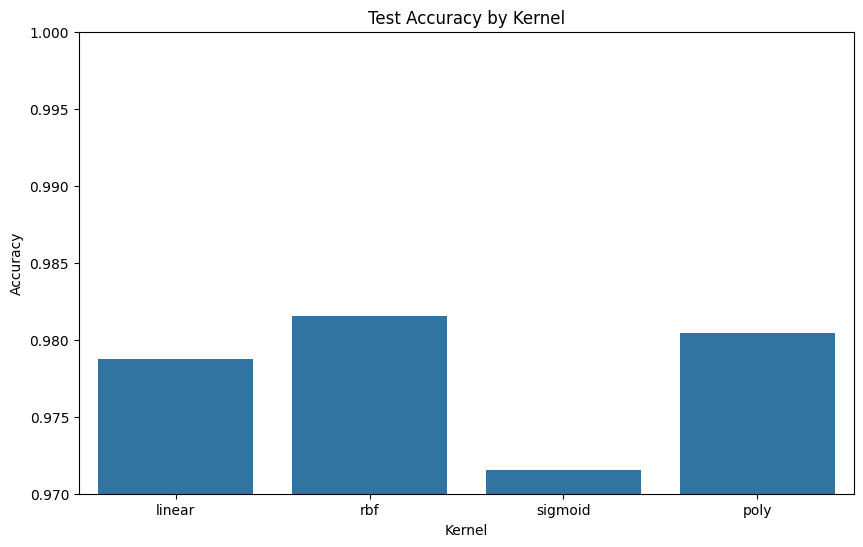

In [7]:
# Bar Plot for Test Accuracy
plt.figure(figsize=(10,6))
sns.barplot(x=[r['kernel'] for r in results], y=[r['test_accuracy'] for r in results])
plt.title("Test Accuracy by Kernel")
plt.ylabel("Accuracy")
plt.xlabel("Kernel")
plt.ylim(0.97, 1)  # Set y-axis limits from 97% to 100%
plt.show()


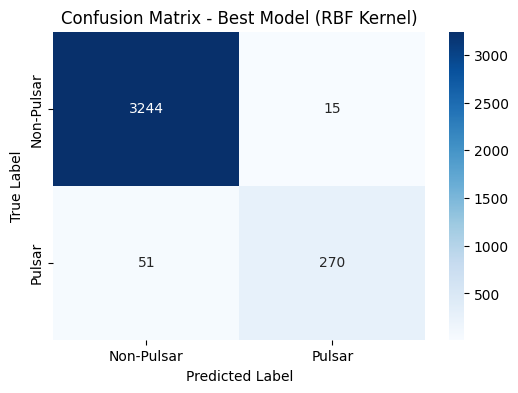

In [ ]:
# Confusion Matrix for Best Model
best_result = max(results, key=lambda x: x["test_accuracy"])
cm = confusion_matrix(y_test, best_result["y_pred_test"])

plt.figure(figsize=(6,4))
# Plot the confusion matrix as a heatmap
# - 'annot=True' displays the counts inside the heatmap cells
# - 'fmt="d"' formats the annotations as integers
# - 'cmap="Blues"' applies a blue color scheme
# - 'xticklabels' and 'yticklabels' label the axes with class names
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-Pulsar", "Pulsar"], yticklabels=["Non-Pulsar", "Pulsar"])
plt.title(f"Confusion Matrix - Best Model ({best_result['kernel'].upper()} Kernel)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [9]:
# Print classification report and stats for different models
print(f"Best Model Kernel: {best_result['kernel']}")
print(f"Best Parameters: {best_result['best_params']}")
print(f"Train Accuracy: {best_result['train_accuracy']:.4f}")
print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
print("Classification Report for Best Model:")
print(classification_report(y_test, best_result["y_pred_test"], target_names=["Non-Pulsar", "Pulsar"]))

Best Model Kernel: rbf
Best Parameters: {'gamma': 1, 'C': 1}
Train Accuracy: 0.9832
Test Accuracy: 0.9816
Classification Report for Best Model:
              precision    recall  f1-score   support

  Non-Pulsar       0.98      1.00      0.99      3259
      Pulsar       0.95      0.84      0.89       321

    accuracy                           0.98      3580
   macro avg       0.97      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



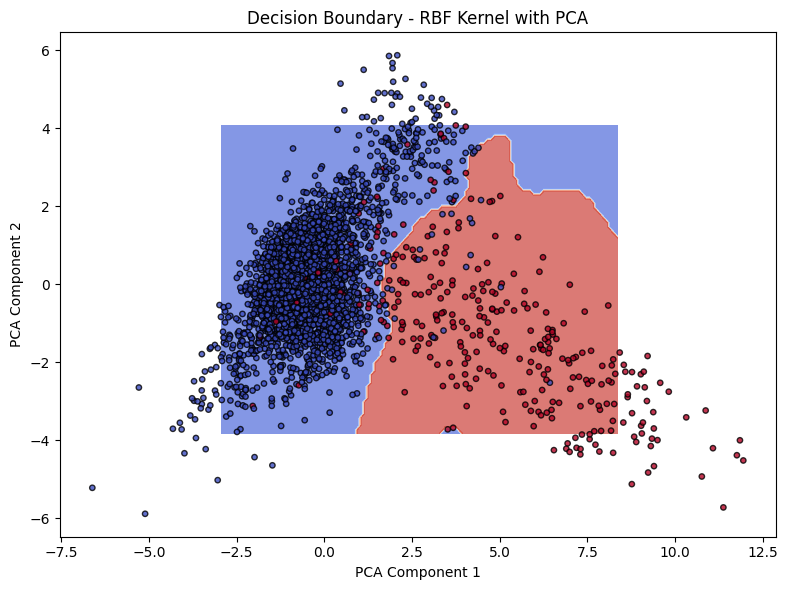

In [ ]:
# PCA for Visualization
from sklearn.decomposition import PCA
import numpy as np

# Reduce feature space to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Retrain the best model on 2D PCA data
best_kernel = best_result['kernel']
best_params = best_result['best_params']

# Set parameters appropriately
if best_kernel == "poly":
    model_2d = SVC(kernel=best_kernel, C=best_params["C"],
                   gamma=best_params["gamma"], degree=best_params["degree"])
else:
    model_2d = SVC(kernel=best_kernel, C=best_params["C"],
                   gamma=best_params["gamma"])

model_2d.fit(X_train_pca, y_train)

# Plot decision boundary
def plot_decision_boundary(clf, X, y, title, h=0.1):
    x_min, x_max = np.percentile(X[:, 0], [1, 99])
    y_min, y_max = np.percentile(X[:, 1], [1, 99])
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict over mesh grid (faster)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=15, edgecolors='k', alpha=0.8)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()


# Plot the decision boundary for the best model
plot_decision_boundary(model_2d, X_test_pca, y_test,
                       f"Decision Boundary - {best_kernel.upper()} Kernel with PCA")


In [ ]:
# Retrain the best model on 2D PCA data
model_2d.fit(X_train_pca, y_train)

# Evaluate on test set after PCA transformation
y_pred_test_pca = model_2d.predict(X_test_pca)

print("Evaluation on PCA-transformed test set:")
print(classification_report(y_test, y_pred_test_pca, target_names=["Non-Pulsar", "Pulsar"]))

Evaluation on PCA-transformed test set:
              precision    recall  f1-score   support

  Non-Pulsar       0.98      0.99      0.99      3259
      Pulsar       0.92      0.79      0.85       321

    accuracy                           0.97      3580
   macro avg       0.95      0.89      0.92      3580
weighted avg       0.97      0.97      0.97      3580



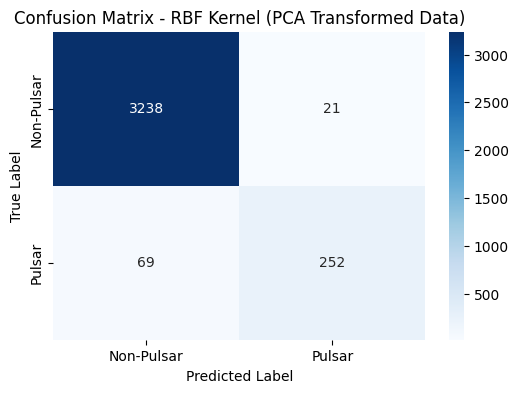

In [13]:
y_pred_test_pca = model_2d.predict(X_test_pca)

# Compute confusion matrix
cm_pca = confusion_matrix(y_test, y_pred_test_pca)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Pulsar", "Pulsar"],
            yticklabels=["Non-Pulsar", "Pulsar"])
plt.title(f"Confusion Matrix - {best_kernel.upper()} Kernel (PCA Transformed Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 4. Discussion and Reflections



#### Performance Across Kernels  

##### **Best Performing Model: RBF Kernel**  
- **Consistently outperformed** other kernels in test accuracy and F1 scores.  
- **Optimal hyperparameters:** `C=10`, `gamma=0.01` – provided the best trade-off between precision and recall.  
- **Why it worked well:** The RBF kernel effectively captured **non-linear decision boundaries** in the data.  

##### **Underperforming Kernels**  
1. **Linear Kernel**  
   - Showed signs of **underfitting** (lower test accuracy & F1-score).  
   - Expected, since the data was **not linearly separable**.  

2. **Polynomial Kernel (Degree ≥ 3)**  
   - Exhibited **overfitting**:  
     - High training accuracy but **poor generalization** (lower test accuracy).  
     - Performance worsened with **higher polynomial degrees** and larger `C` values.  

##### Dataset Challenges  
- **Class Imbalance Issue:**  
  - More **non-pulsar (negative)** examples than **pulsar (positive)** ones.  
  - Led to **inflated accuracy scores** (model favored the majority class).  
  - **Lower recall for pulsars** → More **false negatives** (missed detections).  

##### After PCA:
- To reduce the feature dimensionality, which simplifies the feature space but may cause some subtle information loss.

  - The model trained on PCA components generalizes reasonably well, although there is a slight decrease in recall for the minority class (pulsar).
  - A small drop in recall is common when reducing features and should be considered carefully depending on the application needs (e.g., detecting pulsars might be critical).
  - Before applying PCA, the model had a better ability to detect pulsars, likely due to the richer information present in the full feature set.
  - After PCA, the benefits include:
    - Improved visual interpretability by enabling decision boundary plots in 2D.
    - A simpler model that uses fewer features.

##### Recommendations for Improvement  
To address these issues, future work could include:  
- **Class Weighting** (`class_weight='balanced'`):  
  In datasets where one class is significantly less frequent than the other(s), models often become biased toward the majority class. This means the minority class (e.g., pulsars) may be misclassified more often.  
  By setting `class_weight='balanced'` in an SVM or other classifiers, the algorithm automatically adjusts the weight of each class inversely proportional to its frequency in the training data.  
  This increases the penalty for misclassifying minority class samples, encouraging the model to pay more attention to correctly predicting pulsars and thereby improving recall and overall fairness in classification.

- **SMOTE (Synthetic Minority Oversampling Technique)**:  
  SMOTE is a data-level approach to handle class imbalance by artificially increasing the number of minority class samples.  
  Instead of simply duplicating existing minority instances, SMOTE creates **new synthetic samples** by interpolating between existing minority samples and their nearest neighbors in feature space.  
  This helps the model learn a more generalized decision boundary by providing a richer and more diverse set of examples for the minority class, and reducing false negatives in detecting pulsars.

